# Baseline using FIR filter to perform denoising then send to classifier

### The most corrupted ECG signal(SNR=-6dB)

In [1]:
import wfdb
from biosppy.signals import ecg
import numpy as np
import matplotlib.pyplot as plt
filename = '../../mit-bih-noise-stress-test-database-1.0.0/119e_6'
signal, fields = wfdb.rdsamp(filename)
annotation = wfdb.rdann(filename, 'atr')
MLII_raw = signal[:, 0]
plt.figure(figsize=(12, 4))
plt.plot(range(len(MLII_raw[:1000])), MLII_raw[:1000])

### After FIR filtering

/usr/local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/usr/local/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/usr/local/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.ar

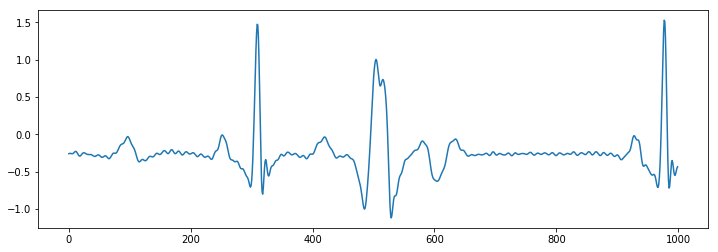

In [2]:
MLII = ecg.ecg(MLII_raw, fields['fs'], show=False)
plt.figure(figsize=(12, 4))
plt.plot(range(len(MLII['filtered'][:1000])), MLII['filtered'][:1000])

### Segmentation

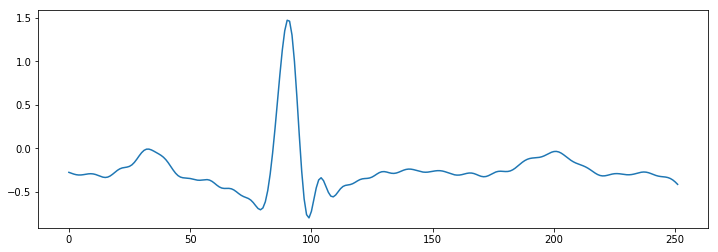

In [3]:
fs = fields['fs']
segments = []
for timestamp in MLII['rpeaks']:
    segments.append(MLII['filtered'][int(timestamp-0.25*fs):int(timestamp+0.45*fs)])
plt.figure(figsize=(12, 4))
plt.plot(range(len(segments[0])), segments[0])

### Classification inference

In [4]:
from ECG_classifier import Model
import torch
encoding = '.NLRAaJSVF[!]ejE/fxQ|'
model = Model().cuda()
model.load_state_dict(torch.load('ECG_classifier_params.pth'))
out = model(torch.tensor(segments).float().cuda())
_, pred = torch.max(out, 1)

label_pred = []
for i in pred:
    label_pred.append(encoding[i])

### Evaluate

In [5]:
def matrix(ts_pred, label_pred, ts, label, fs, tol=0.05):
    tol = tol * fs
    TP = 0
#     FP = 0
    matchIdx = []

    for i, r in enumerate(ts_pred):
        ti = np.argmin(np.abs(ts-r))
        t = ts[ti] # find closest timestamp in all of the ground truth
        error = np.abs(t-r)

        if error < tol:
            if label_pred[i] == label[ti]:
                TP += 1
#         else:
#             if len(matchIdx) > 0:
#                 bdf = r - test[matchIdx[-1]]
#                 if bdf < minRR:
#                     # false positive, but removable with RR interval check
#                     pass
#                 else:
#                     FP += 1
#             else:
#                 FP += 1
    return {
        'performance': TP/len(ts)
    }

In [6]:
matrix(MLII['rpeaks'], label_pred, annotation.sample, annotation.symbol, fields['fs'])['performance']

0.44173829990448904

## Perform on all of the dataset

In [7]:
fname_prefix = '../../mit-bih-noise-stress-test-database-1.0.0/'
flist = ['118e_6', '118e00', '118e06', '118e12', '118e18', '118e24', '119e_6', '119e00', '119e06', '119e12', '119e18', '119e24']
perf_list = []
for f in flist:
    signal, fields = wfdb.rdsamp(fname_prefix+f)
    annotation = wfdb.rdann(fname_prefix+f, 'atr')
    MLII_raw = signal[:, 0]
    MLII = ecg.ecg(MLII_raw, fields['fs'], show=False)
    fs = fields['fs']
    segments = []
    for timestamp in MLII['rpeaks']:
        segments.append(MLII['filtered'][int(timestamp-0.25*fs):int(timestamp+0.45*fs)])
        
    out = model(torch.tensor(segments).float().cuda())
    _, pred = torch.max(out, 1)
    label_pred = []
    for i in pred:
        label_pred.append(encoding[i])
    perf = matrix(MLII['rpeaks'], label_pred, annotation.sample, annotation.symbol, fields['fs'])['performance']
    print(f, perf)
    perf_list.append(perf)

/usr/local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/usr/local/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/usr/local/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.ar

118e_6 0.08257279443720121
118e00 0.14732724902216426
118e06 0.13906996957844414
118e12 0.12863972186006084
118e18 0.1282051282051282
118e24 0.12559756627553237
119e_6 0.44221585482330467
119e00 0.5926456542502387
119e06 0.7043935052531041
119e12 0.724450811843362
119e18 0.7015281757402101
119e24 0.7077363896848138


In [8]:
%%html
<style>
table {float:left}
</style>

### Result

Dataset  | Performance
---------|------------
118e_6   | 0.08
118e00   | 0.14
118e06   | 0.13
118e12   | 0.12
118e18   | 0.12
118e24   | 0.12
119e_6   | 0.44
119e00   | 0.59
119e06   | 0.70
119e12   | 0.72
119e18   | 0.70
119e24   | 0.70
         |